# LLM architecture

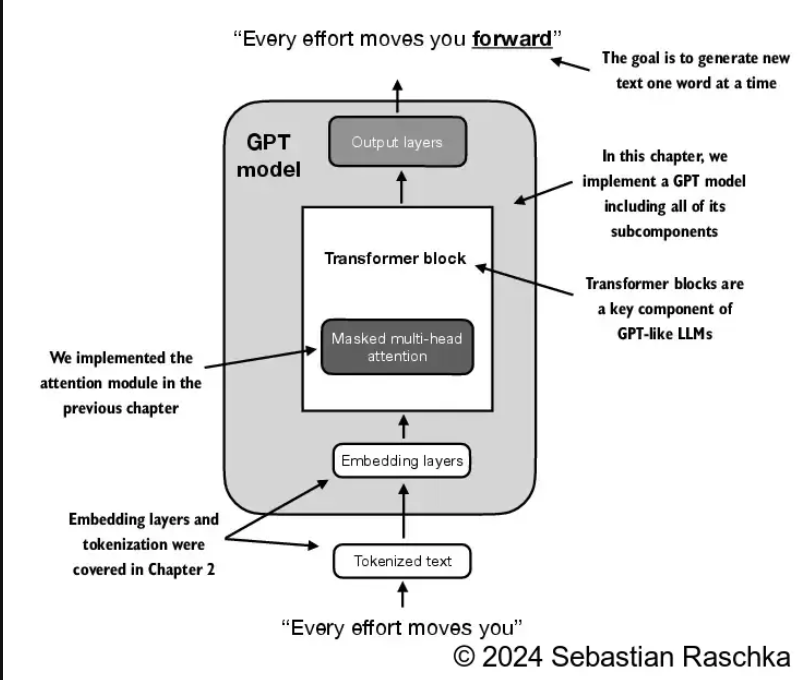

## transformer block
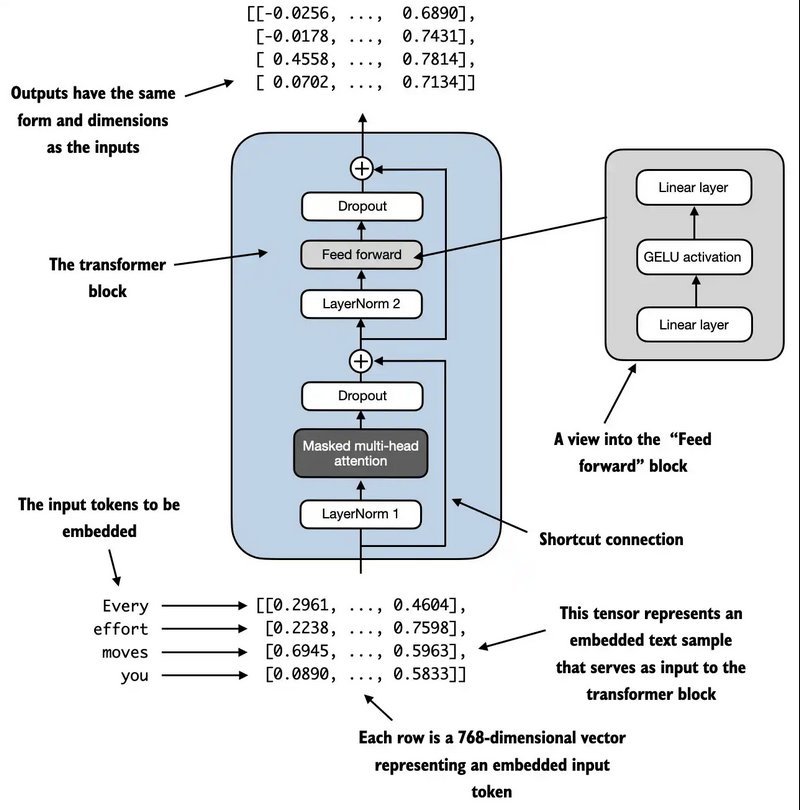


# Implementing a GPT Model from scratch to generate text (GPT-2)

## GPT Architecture part 1: Dummy GPT Model Class

Step 1: Use a placeholder for TransformerBlock

Step 2: Use a placeholder for LayerNorm

In [45]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,                # Vocabulary size
    "context_length": 1024,             # Context length
    "emb_dim": 768 ,                    # Embedding dimension
    "n_heads": 12 ,                     # Number of attention heads 
    "n_layers": 12,                     # Number of layers 
    "dropout": 0.1 ,                    # Dropout Rate 
    "qkv_bias": False                   # Query-Key-Value bias
}

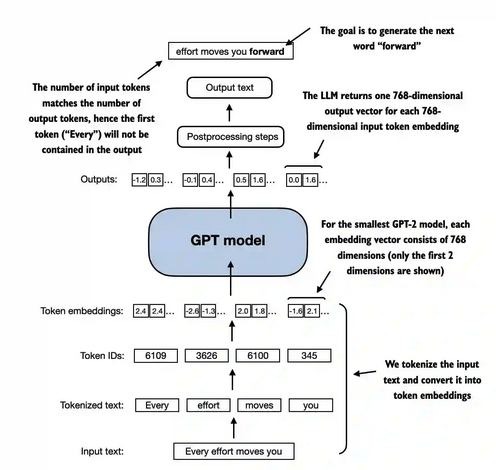

In [9]:
import torch
import torch.nn as nn 

class DummyGPTModel(nn.Module): 
    
    def __init__(self , cfg):
        
        super().__init__()
        
        # token embedding would be the size of vocabulary and embedding dimensions
        self.token_emb = nn.Embedding(cfg['vocab_size'] , cfg['emb_dim'] )
        
        # positional embedding would be the size of vocabulary and embedding dimensions
        self.position_emb = nn.Embedding(cfg['context_length'] , cfg['emb_dim'])
        
        # Define the embeddings dropout
        self.drop_emb = nn.Dropout(cfg['dropout'])
        
        #placeholder for TransformerBlock 
        self.trf_block = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # placeholder for LayerNorm 
        self.final_norm = DummyLayerNorm(cfg['emb_dim'])
        
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
        
        
    def forward(self , in_idx): 
        batch_size , seq_len = in_idx.shape
        
        # calculate the token and positional embeddings
        token_embeddings = self.token_emb(in_idx)
        positional_embeddings = self.position_emb(torch.arange(seq_len , device = in_idx.device))
        
        # add the two together to get the final embeddings
        final_embeddigs = token_embeddings + positional_embeddings
        
        # Run dropout on the final embeddings 
        final_embeddigs = self.drop_emb(final_embeddigs)
        
        # run the dummy transformer block 
        final_embeddigs = self.trf_block(final_embeddigs)
        
        #run the dummylayernorm block 
        final_embeddigs = self.final_norm(final_embeddigs)
        
        #run thhe out block 
        logits = self.out_head(final_embeddigs)
        
        return logits 
    
    
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder  
        
    def forward(self,x): 
        return x 
    
class DummyLayerNorm(nn.Module):
    def __init__(self,normalized_shape, eps=1e-5):
        super().__init__()
        # A simple placeholder  
        
    def forward(self,x): 
        return x            
        
        
        
        
        
        
        

### Lets run an example

In [10]:
import tiktoken

tokenizer = tiktoken.get_encoding('gpt2')

batch = []

txt1 = "Every effort moves you"

txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))

batch = torch.stack(batch , dim = 0)

print(batch)


tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [46]:
torch.manual_seed(123)

model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)

print(f'Output Shape = {logits.shape}')

print(logits)

Output Shape = torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


## GPT Architecture part 2: Layer normalization

Training deep NN with many layers can be challeneging due to vanishing/exploding gradients

Which leads to unstable training dynamics

Layer normalization improves the stability 

Main Idea: Adjust output of the layernormalization is to have the outputs of NN to have mean of 0 and variance of 1

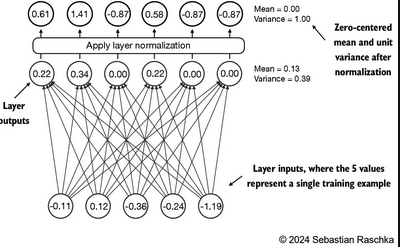

Layer normalization is applied both before and after the multi-head attention module within the transformer block, and it's also applied before the final output layer

### Lets start with a small example before we code it in the gpt class

In [14]:
torch.manual_seed(123)
batch_example = torch.rand(2,5)
print(batch_example)


layer = nn.Sequential(nn.Linear(5,6) , nn.ReLU())

out = layer(batch_example)

print(out)

tensor([[0.2961, 0.5166, 0.2517, 0.6886, 0.0740],
        [0.8665, 0.1366, 0.1025, 0.1841, 0.7264]])
tensor([[0.0000, 0.0000, 0.4091, 0.6587, 0.3914, 0.0000],
        [0.0000, 0.0000, 0.1902, 0.3182, 0.6486, 0.0000]],
       grad_fn=<ReluBackward0>)


In [15]:
# calculate the mean and variance 

mean = out.mean(dim = -1 , keepdim=True)
variance = out.var(dim = -1 , keepdim=True)

print(f'Mean = {mean}')

print(f'Variance = {variance}')


Mean = tensor([[0.2432],
        [0.1928]], grad_fn=<MeanBackward1>)
Variance = tensor([[0.0799],
        [0.0670]], grad_fn=<VarBackward0>)


In [18]:
# Subtract the mean and divide by the variance 

out_norm =( out - mean )/ torch.sqrt(variance)

print(f'Output Normalizer = {out_norm}')

print(f'Mean of the out_norm = {out_norm.mean(dim = -1 , keepdim = True)}')

print(f'Varaince of the out_norm = {out_norm.var(dim = -1 , keepdim = True)}')


Output Normalizer = tensor([[-0.8603, -0.8603,  0.5869,  1.4698,  0.5242, -0.8603],
        [-0.7450, -0.7450, -0.0102,  0.4844,  1.7608, -0.7450]],
       grad_fn=<DivBackward0>)
Mean of the out_norm = tensor([[ 0.0000e+00],
        [-9.9341e-09]], grad_fn=<MeanBackward1>)
Varaince of the out_norm = tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


Its not exactly zero.. we can turn off the scientific mode 

In [19]:
torch.set_printoptions(sci_mode=False)
print(f'Mean of the out_norm = {out_norm.mean(dim = -1 , keepdim = True)}')

print(f'Varaince of the out_norm = {out_norm.var(dim = -1 , keepdim = True)}')

Mean of the out_norm = tensor([[     0.0000],
        [    -0.0000]], grad_fn=<MeanBackward1>)
Varaince of the out_norm = tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


### Now lets code it as a function

In [31]:
class LayerNorm(nn.Module):
    def __init__(self,emb_dim):
        
        super().__init__()
        
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        
    def forward(self , x): 
        mean = x.mean(dim = -1 , keepdim = True)
        variance = x.var(dim = -1 , keepdim = True , unbiased = False) # bessles correction using (n-1) instead of n for variance denominator
        
        norm_x = (x-mean) / torch.sqrt(variance + self.eps) # eps is to avoid division by zero error
        
        return self.scale * norm_x + self.shift # Scale and shift and two traininable parameters. 

In [37]:
ln = LayerNorm(emb_dim = 6)

print(ln(out)) 

print(f'Mean of the out_norm = \n {ln(out).mean(dim = -1 , keepdim = True)}')

print(f'Varaince of the out_norm = \n {ln(out).var(dim = -1 ,unbiased = False,  keepdim = True)}')

tensor([[-0.9423, -0.9423,  0.6428,  1.6100,  0.5742, -0.9423],
        [-0.8160, -0.8160, -0.0111,  0.5306,  1.9286, -0.8160]],
       grad_fn=<AddBackward0>)
Mean of the out_norm = 
 tensor([[     0.0000],
        [    -0.0000]], grad_fn=<MeanBackward1>)
Varaince of the out_norm = 
 tensor([[0.9998],
        [0.9998]], grad_fn=<VarBackward0>)


## GPT Architecture part 3: GELU activation

The main obj is to implement a small NN sub-module that is a the part of the LLM transformer block

Two activations veru commonly used in LLM are 
    GELU 
    SwiGELU 

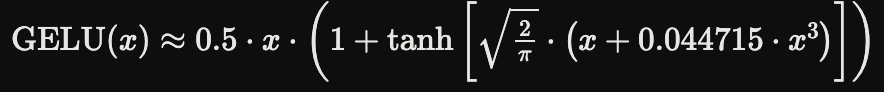

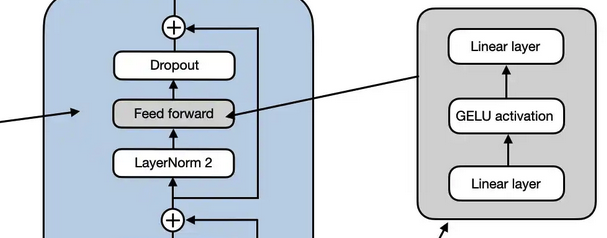

### Lets create a class for it

In [38]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

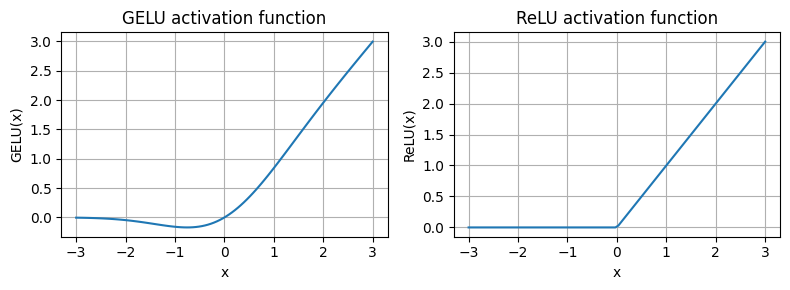

In [39]:

import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()



Advantages: 

GELU is smooth growth at 0 

isnt zero for negative (prevent dead neuron problem)

Usually works better in LLM

### Lets create the feedforward class

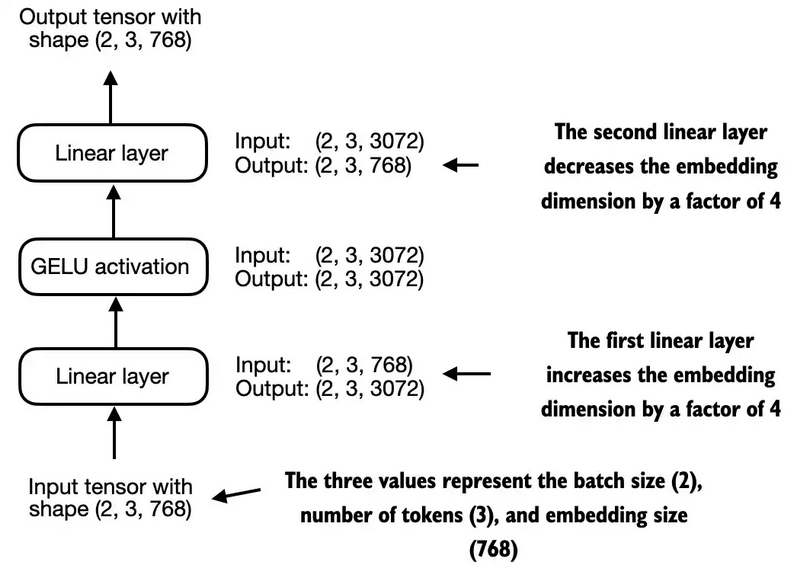

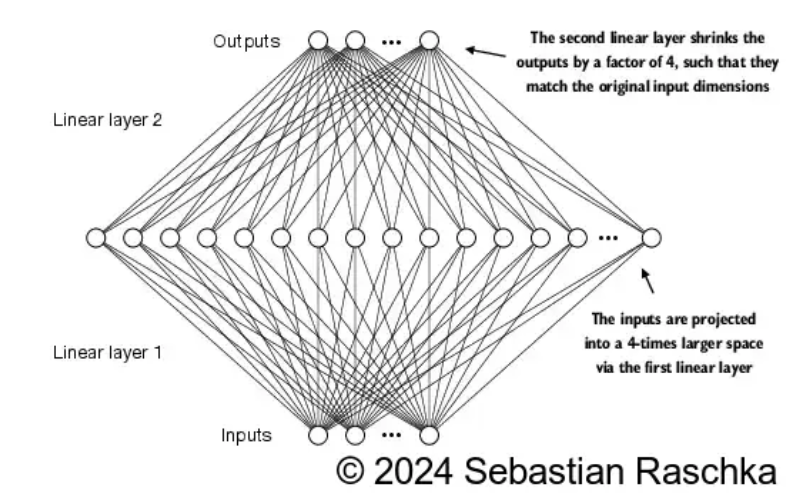

In [52]:
class FeedForward(nn.Module):
    
    def __init__(self , cfg): 
        
        super().__init__()
        self.layers = nn.Sequential(
                nn.Linear(cfg['emb_dim'] , 4 * cfg['emb_dim']),                    # first linear layer (EXPANSION)
                GELU(),                                                     # GELU Activation Layer 
                nn.Linear(4 * cfg['emb_dim'] ,cfg['emb_dim']),          # Second linear layer (CONTRACTION)
            ) 
        
        
    def forward(self , x): 
        return self.layers(x)
        

In [56]:
ffn = FeedForward(GPT_CONFIG_124M)

x = torch.rand(2,3,768)

print(f'Input size = {x.shape}')

out = ffn(x)


print(f'Output size = {out.shape}')

Input size = torch.Size([2, 3, 768])
Output size = torch.Size([2, 3, 768])


## GPT Architecture part 4: Shortcut connections

Shortcut connections are also called as skip connections. 

They were introduced mainly to solve the problem of vanishing gradients 

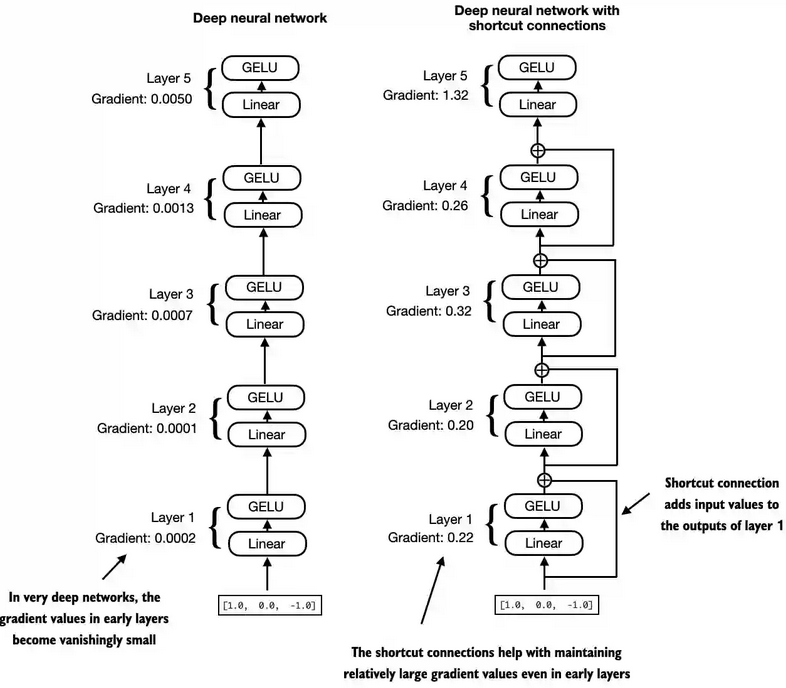

In [68]:
class ExampleDeepNeuralNetwrok(nn.Module):
    
    def __init__(self , layer_sizes , use_shortcut): 
        
        super().__init__()
        self.use_shortcut = use_shortcut
        
        self.layers = nn.ModuleList([
            
            nn.Sequential(nn.Linear(layer_sizes[0] , layer_sizes[1]) , GELU()), 
            nn.Sequential(nn.Linear(layer_sizes[1] , layer_sizes[2]) , GELU()), 
            nn.Sequential(nn.Linear(layer_sizes[2] , layer_sizes[3]) , GELU()), 
            nn.Sequential(nn.Linear(layer_sizes[3] , layer_sizes[4]) , GELU()), 
            nn.Sequential(nn.Linear(layer_sizes[4] , layer_sizes[5]) , GELU()), 
        ])
        
    def forward(self , x): 
        for layer in self.layers: 
            
            #calculate the output of the current layer
            layer_output = layer(x)
            
            # check for shortcut connections
            
            if (self.use_shortcut and x.shape == layer_output.shape):
                x = x + layer_output
            else: 
                x = layer_output
            
        return x
    
def print_gradients(model , x): 
    
    #forward pass
    
    output = model(x)
    target = torch.tensor([[0.]])
    
    #calculate the loss 
    
    loss = nn.MSELoss()
    loss = loss(output , target)
    
    #backward pass the loss 
    loss.backward()
    
    for name,param in model.named_parameters():
        if 'weight' in name: 
            #print the mean absolute gradient 
            
            print(f'{name} has gradient mean of {param.grad.abs().mean().item()}')
             

Lets print the gradient value

In [69]:
layer_sizes = [3,3,3,3,3,1]

sample_input = torch.tensor([[1. , 0. , -1.]])

torch.manual_seed(123)

model_without_shortcut = ExampleDeepNeuralNetwrok(layer_sizes , use_shortcut=False)

print_gradients(model_without_shortcut,sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152039906941354
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


In [70]:
layer_sizes = [3,3,3,3,3,1]

sample_input = torch.tensor([[1. , 0. , -1.]])

torch.manual_seed(123)

model_without_shortcut = ExampleDeepNeuralNetwrok(layer_sizes , use_shortcut=True)

print_gradients(model_without_shortcut,sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


This solves the vanishing gradient problem

## GPT Architecture part 5: Build the whole transformer block

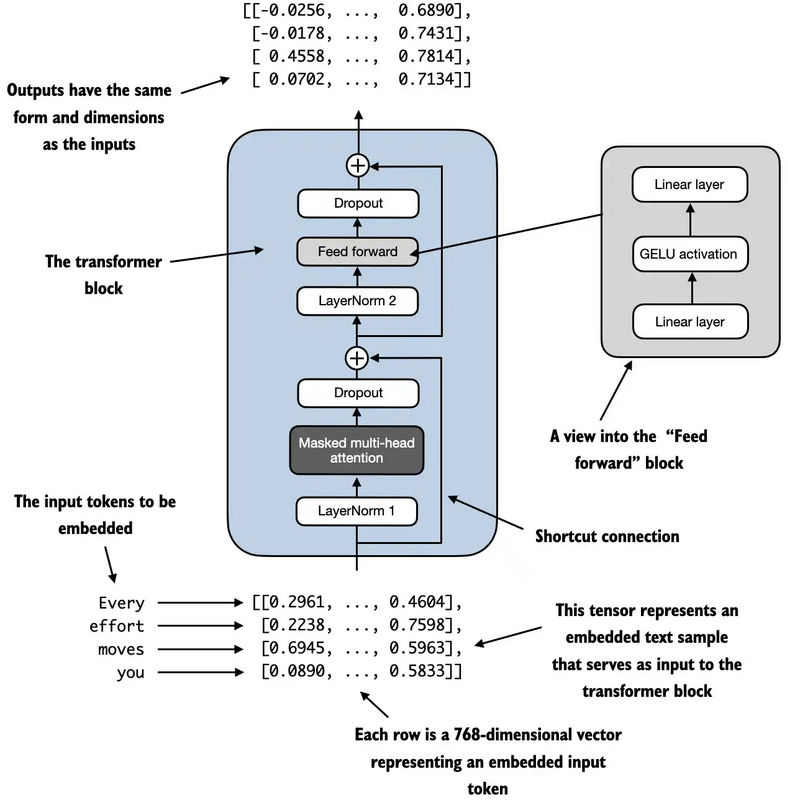

In [71]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,                # Vocabulary size
    "context_length": 1024,             # Context length
    "emb_dim": 768 ,                    # Embedding dimension
    "n_heads": 12 ,                     # Number of attention heads 
    "n_layers": 12,                     # Number of layers 
    "dropout": 0.1 ,                    # Dropout Rate 
    "qkv_bias": False                   # Query-Key-Value bias
}

### The building blocks: MultiheadAttention block,  layer normalization , GELU and FeedForward Network

In [75]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self , d_in , d_out , context_length , dropout , num_heads , qkv_bias = False):
        super().__init__()
        
        assert(d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"
            
        self.d_out = d_out 
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads 
        
        self.W_query = nn.Linear(d_in , d_out , bias = qkv_bias)
        self.W_key = nn.Linear(d_in , d_out , bias = qkv_bias)
        self.W_value = nn.Linear(d_in , d_out , bias = qkv_bias)
        
        self.dropout = nn.Dropout(dropout)
        self.out_proj = nn.Linear(d_out , d_out)
        self.register_buffer(
            "mask" , 
            torch.triu(torch.ones(context_length , context_length), diagonal=1)
        )
        
    def forward(self , x): 
        
        b , num_token , d_in = x.shape
        
        keys = self.W_key(x) # shape = b , num_token , d_out
        values = self.W_value(x)
        queries = self.W_query(x)
        
        # split the above matrices into 4-D Byh adding in num_heads into the dimentions 
        
        keys = keys.view(b , num_token , self.num_heads , self.head_dim )
        values = values.view(b , num_token , self.num_heads , self.head_dim )
        queries = queries.view(b , num_token , self.num_heads , self.head_dim )
        
        # transpose - b , num_token , self.num_heads , self.head_dim ---> b , self.num_heads , num_token , self.head_dim
        
        keys = keys.transpose(1,2)
        values = values.transpose(1,2)
        queries = queries.transpose(1,2)
        
        # Compute scaled dot product attemtion 
        
        atten_score = queries @ keys.transpose(2,3) # b , self.num_heads , num_token , num_token
        
        # Use mask to only look at attention for the tokens seen 
        
        mask_bool = self.mask.bool()[:num_token , :num_token]
        
        # use the mask 
        atten_score.masked_fill_(mask_bool, -torch.inf)
        
        # calculate attention wieghts 
        
        atten_weights = torch.softmax(atten_score/keys.shape[-1] ** 0.5 , dim = -1) # b , self.num_heads , num_token , num_token
        
        atten_weights = self.dropout(atten_weights)
        
        context_vec = atten_weights @ values  # b , self.num_heads , num_token , self.head_dim
        
        context_vec = context_vec.transpose(1,2) # b , num_token  , self.num_heads , self.head_dim
        
        # combine heads 
        context_vec = context_vec.contiguous().view(b , num_token , self.d_out) # b , num_token  , self.d_out
        context_vec = self.out_proj(context_vec)
        
        return context_vec

In [72]:
class LayerNorm(nn.Module):
    def __init__(self,emb_dim):
        
        super().__init__()
        
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        
    def forward(self , x): 
        mean = x.mean(dim = -1 , keepdim = True)
        variance = x.var(dim = -1 , keepdim = True , unbiased = False) # bessles correction using (n-1) instead of n for variance denominator
        
        norm_x = (x-mean) / torch.sqrt(variance + self.eps) # eps is to avoid division by zero error
        
        return self.scale * norm_x + self.shift # Scale and shift and two traininable parameters. 

In [73]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [74]:
class FeedForward(nn.Module):
    
    def __init__(self , cfg): 
        
        super().__init__()
        self.layers = nn.Sequential(
                nn.Linear(cfg['emb_dim'] , 4 * cfg['emb_dim']),                    # first linear layer (EXPANSION)
                GELU(),                                                     # GELU Activation Layer 
                nn.Linear(4 * cfg['emb_dim'] ,cfg['emb_dim']),          # Second linear layer (CONTRACTION)
            ) 
        
        
    def forward(self , x): 
        return self.layers(x)

Step 1: Shortcut connection for attention block 

Step 2: Shortcut connection for the feed forward block 

Step 3: Add the original input back

In [83]:
class TransformerBlock(nn.Module): 
    
    def __init__(self , cfg): 
        
        super().__init__()
        
        self.att = MultiHeadAttention(
            d_in = cfg['emb_dim'],
            d_out = cfg['emb_dim'],
            context_length = cfg['context_length'],
            dropout = cfg['dropout'],
            num_heads = cfg['n_heads'],
            qkv_bias = cfg['qkv_bias']  
        )
        
        self.ff = FeedForward(cfg)
        
        self.norm1 = LayerNorm(cfg['emb_dim'])
        
        self.norm2 = LayerNorm(cfg['emb_dim'])
        
        self.dropout_shortcut = nn.Dropout(cfg['dropout'])
        
        
    def forward(self , x): 
        
        # Shortcut connection for the attention block 
        shortcut  = x 
        
        x = self.norm1(x)
        x = self.att(x)
        x = self.dropout_shortcut(x)
        x = x + shortcut
        
        # shortcut connection for feedforward 
        shortcut = x 
        
        x = self.norm2(x)
        x = self.ff(x)
        x = self.dropout_shortcut(x)
        
        x = x + shortcut
        
        return x 
    
    

### Lets run an example through the transformer block

In [85]:
torch.manual_seed(123)

x = torch.rand(2,4,768)

block = TransformerBlock(GPT_CONFIG_124M)

output = block(x)

print(f'Input shape = {x.shape}')
print(f'Output shape = {output.shape}')

print(output)

Input shape = torch.Size([2, 4, 768])
Output shape = torch.Size([2, 4, 768])
tensor([[[-0.0055,  0.0972, -0.1122,  ...,  1.2889,  0.2623,  0.6685],
         [ 0.0023, -0.2369,  0.1720,  ...,  0.5952,  0.2497,  0.7447],
         [ 0.4673,  0.4472,  0.1791,  ...,  1.2525,  0.3045,  0.7750],
         [ 0.0662,  0.7224,  0.9206,  ...,  0.4790,  0.7428,  0.7015]],

        [[ 0.3622,  1.2144,  0.5221,  ...,  0.1854,  0.0111, -0.5034],
         [-0.0225,  0.7789,  0.2770,  ...,  0.1734,  0.5419,  0.1143],
         [ 0.7425,  0.4013,  0.3211,  ...,  0.3268,  0.7523, -0.1642],
         [ 0.5745,  0.6241,  0.4410,  ...,  1.1963,  1.2650,  0.2243]]],
       grad_fn=<AddBackward0>)


## GPT Architecture part 6: Code the whole GPT Model

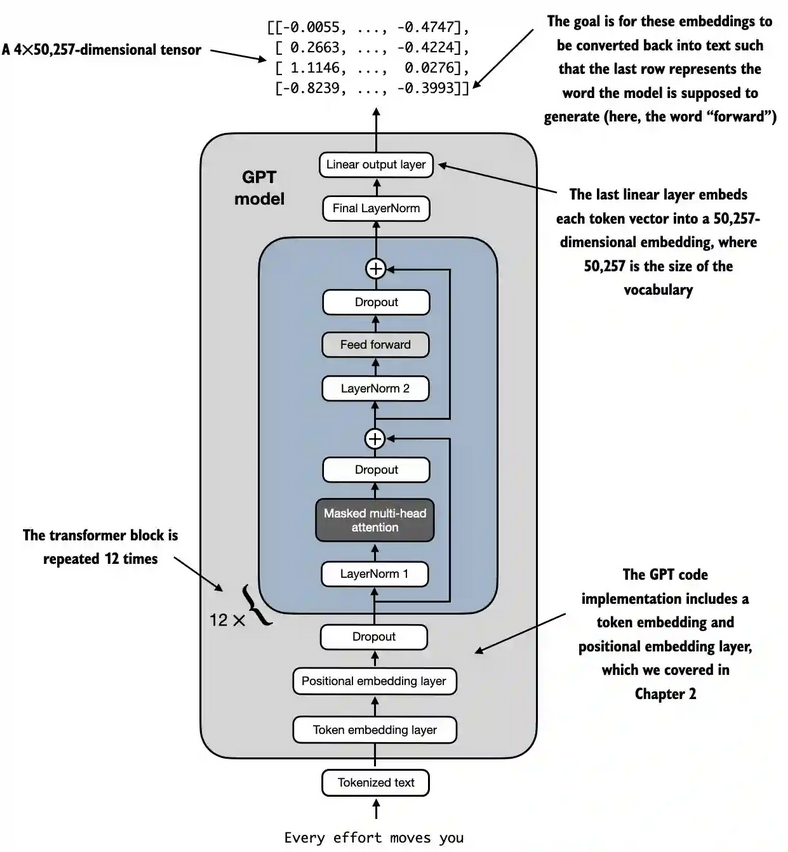

In [86]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,                # Vocabulary size
    "context_length": 1024,             # Context length
    "emb_dim": 768 ,                    # Embedding dimension
    "n_heads": 12 ,                     # Number of attention heads 
    "n_layers": 12,                     # Number of layers 
    "dropout": 0.1 ,                    # Dropout Rate 
    "qkv_bias": False                   # Query-Key-Value bias
}

In [87]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self , d_in , d_out , context_length , dropout , num_heads , qkv_bias = False):
        super().__init__()
        
        assert(d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"
            
        self.d_out = d_out 
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads 
        
        self.W_query = nn.Linear(d_in , d_out , bias = qkv_bias)
        self.W_key = nn.Linear(d_in , d_out , bias = qkv_bias)
        self.W_value = nn.Linear(d_in , d_out , bias = qkv_bias)
        
        self.dropout = nn.Dropout(dropout)
        self.out_proj = nn.Linear(d_out , d_out)
        self.register_buffer(
            "mask" , 
            torch.triu(torch.ones(context_length , context_length), diagonal=1)
        )
        
    def forward(self , x): 
        
        b , num_token , d_in = x.shape
        
        keys = self.W_key(x) # shape = b , num_token , d_out
        values = self.W_value(x)
        queries = self.W_query(x)
        
        # split the above matrices into 4-D Byh adding in num_heads into the dimentions 
        
        keys = keys.view(b , num_token , self.num_heads , self.head_dim )
        values = values.view(b , num_token , self.num_heads , self.head_dim )
        queries = queries.view(b , num_token , self.num_heads , self.head_dim )
        
        # transpose - b , num_token , self.num_heads , self.head_dim ---> b , self.num_heads , num_token , self.head_dim
        
        keys = keys.transpose(1,2)
        values = values.transpose(1,2)
        queries = queries.transpose(1,2)
        
        # Compute scaled dot product attemtion 
        
        atten_score = queries @ keys.transpose(2,3) # b , self.num_heads , num_token , num_token
        
        # Use mask to only look at attention for the tokens seen 
        
        mask_bool = self.mask.bool()[:num_token , :num_token]
        
        # use the mask 
        atten_score.masked_fill_(mask_bool, -torch.inf)
        
        # calculate attention wieghts 
        
        atten_weights = torch.softmax(atten_score/keys.shape[-1] ** 0.5 , dim = -1) # b , self.num_heads , num_token , num_token
        
        atten_weights = self.dropout(atten_weights)
        
        context_vec = atten_weights @ values  # b , self.num_heads , num_token , self.head_dim
        
        context_vec = context_vec.transpose(1,2) # b , num_token  , self.num_heads , self.head_dim
        
        # combine heads 
        context_vec = context_vec.contiguous().view(b , num_token , self.d_out) # b , num_token  , self.d_out
        context_vec = self.out_proj(context_vec)
        
        return context_vec

In [88]:
class LayerNorm(nn.Module):
    def __init__(self,emb_dim):
        
        super().__init__()
        
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        
    def forward(self , x): 
        mean = x.mean(dim = -1 , keepdim = True)
        variance = x.var(dim = -1 , keepdim = True , unbiased = False) # bessles correction using (n-1) instead of n for variance denominator
        
        norm_x = (x-mean) / torch.sqrt(variance + self.eps) # eps is to avoid division by zero error
        
        return self.scale * norm_x + self.shift # Scale and shift and two traininable parameters. 
    
    
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))
        
  
class FeedForward(nn.Module):
    
    def __init__(self , cfg): 
        
        super().__init__()
        self.layers = nn.Sequential(
                nn.Linear(cfg['emb_dim'] , 4 * cfg['emb_dim']),                    # first linear layer (EXPANSION)
                GELU(),                                                     # GELU Activation Layer 
                nn.Linear(4 * cfg['emb_dim'] ,cfg['emb_dim']),          # Second linear layer (CONTRACTION)
            ) 
        
        
    def forward(self , x): 
        return self.layers(x)
                   
    

In [89]:
    
class TransformerBlock(nn.Module): 
    
    def __init__(self , cfg): 
        
        super().__init__()
        
        self.att = MultiHeadAttention(
            d_in = cfg['emb_dim'],
            d_out = cfg['emb_dim'],
            context_length = cfg['context_length'],
            dropout = cfg['dropout'],
            num_heads = cfg['n_heads'],
            qkv_bias = cfg['qkv_bias']  
        )
        
        self.ff = FeedForward(cfg)
        
        self.norm1 = LayerNorm(cfg['emb_dim'])
        
        self.norm2 = LayerNorm(cfg['emb_dim'])
        
        self.dropout_shortcut = nn.Dropout(cfg['dropout'])
        
        
    def forward(self , x): 
        
        # Shortcut connection for the attention block 
        shortcut  = x 
        
        x = self.norm1(x)
        x = self.att(x)
        x = self.dropout_shortcut(x)
        x = x + shortcut
        
        # shortcut connection for feedforward 
        shortcut = x 
        
        x = self.norm2(x)
        x = self.ff(x)
        x = self.dropout_shortcut(x)
        
        x = x + shortcut
        
        return x  

In [90]:
class GPTModel(nn.Module): 
    
    def __init__(self , cfg): 
        
        super().__init__()
        
        self.token_emb = nn.Embedding(cfg['vocab_size'] , cfg['emb_dim'])
        self.positional_emb = nn.Embedding(cfg['context_length'] , cfg['emb_dim'])
        
        self.drop_emb = nn.Dropout(cfg['dropout'])
        
        self.transformer_block = nn.Sequential(
            
            *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
            
        )
        
        self.final_norm = LayerNorm(cfg['emb_dim'])
        
        self.out_head = nn.Linear(
            cfg['emb_dim'] , cfg['vocab_size'] , bias = False
        )
        
        
    def forward(self , in_indx): 
        
        batch_size , seq_len = in_indx.shape
        
        token_embeddings = self.token_emb(in_indx)
        position_embeddings = self.positional_emb(torch.arange(seq_len, device = in_indx.device))
        
        x = token_embeddings + position_embeddings
        x= self.drop_emb(x)
        
        x = self.transformer_block(x)
        x = self.final_norm(x)
        
        logits = self.out_head(x)
        
        return logits
        
        

Lets run an example

In [91]:
import tiktoken

tokenizer = tiktoken.get_encoding('gpt2')

batch = []

txt1 = "Every effort moves you"

txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))

batch = torch.stack(batch , dim = 0)

print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [93]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)

out = model(batch)

print(out)

print(f'Output dimension: {out.shape}')

tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)
Output dimension: torch.Size([2, 4, 50257])


In [94]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")


Total number of parameters: 163,009,536


However the gpt had 124M parameters and not 163M 

In GPT2, since output layer and the token embedding layer had the same shape they did weight tying  

In [97]:

print("Token embedding layer shape:", model.token_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)



Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


Removing the parameters from the output layer we get

In [98]:

total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")


Number of trainable parameters considering weight tying: 124,412,160


In [99]:


# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")



Total size of the model: 621.83 MB


## GPT Architecture part 7: Generate text from output tokens

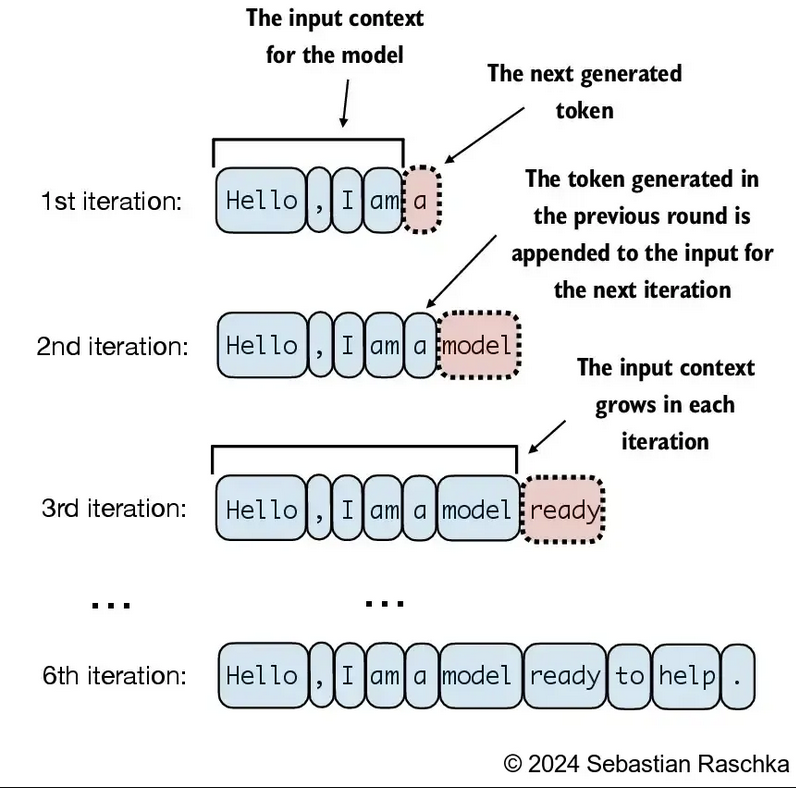

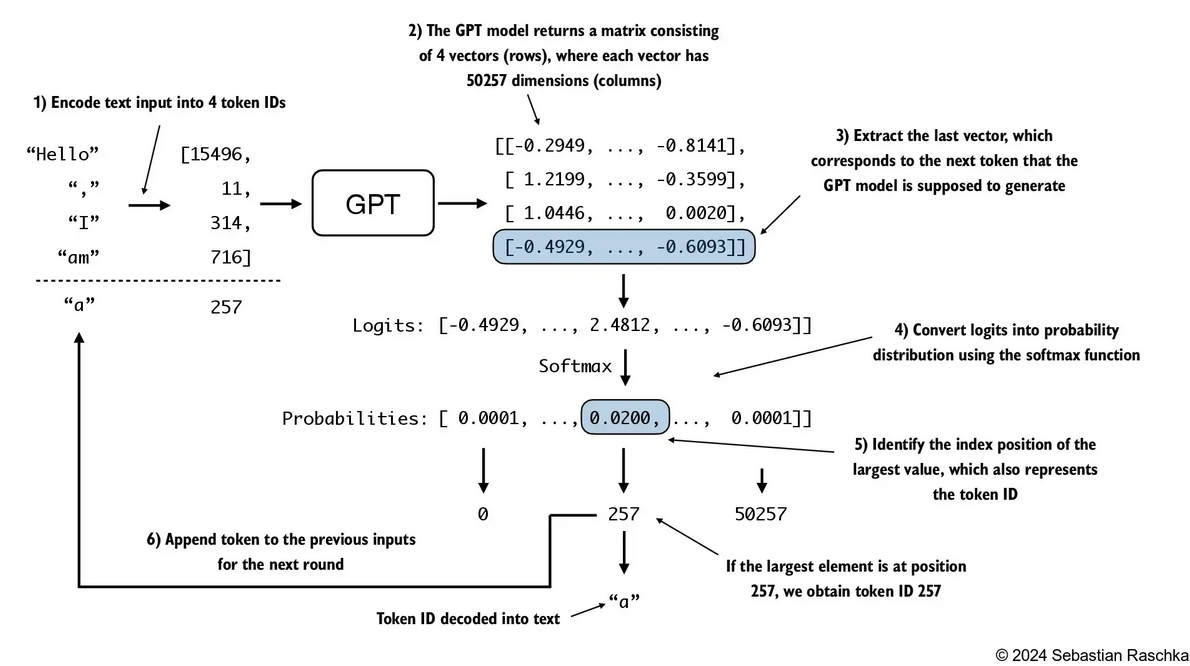

In [ ]:

def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Get the last one per batch
        # (batch, n_tokens, vocab_size) ---> (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax 
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append result index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)
        
        #repeat

    return idx



In [101]:


start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)



encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [102]:
model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))



Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [103]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)


Hello, I am Featureiman Byeswickattribute argue
